In [1]:
from pythtb import TBModel, WFArray, Mesh
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# define lattice vectors and orbitals and make model
lat = [[1, 0], [1/2, np.sqrt(3)/2]]
orb = [[1/3, 1/3], [2/3, 2/3]]

my_model = TBModel(2, 2, lat, orb)

# set model parameters
delta = -0.2
t = -1.0
t2 = 0.05 - 0.15j
t2c = t2.conjugate()

# set on-site energies and hoppings
my_model.set_onsite([-delta, delta])
my_model.set_hop(t, 0, 1, [0, 0])
my_model.set_hop(t, 1, 0, [1, 0])
my_model.set_hop(t, 1, 0, [0, 1])
my_model.set_hop(t2, 0, 0, [1, 0])
my_model.set_hop(t2, 1, 1, [1, -1])
my_model.set_hop(t2, 1, 1, [0, 1])
my_model.set_hop(t2c, 1, 1, [1, 0])
my_model.set_hop(t2c, 0, 0, [1, -1])
my_model.set_hop(t2c, 0, 0, [0, 1])

In [3]:
# number of discretized sites or k-points in the mesh in directions 0 and 1
nk0 = 300
nk1 = 100

mesh = Mesh(my_model)
mesh.build_grid(shape_k=(nk0, nk1), full_grid=True)

In [4]:
my_array = WFArray(my_model, mesh)
my_array.solve_k_mesh()

Auto-imposing PBC in mesh direction 0 for k-component 0
Auto-imposing PBC in mesh direction 1 for k-component 1


In [5]:
phi_1 = my_array.berry_phase(occ=[0], dir=1, contin=True)

In [6]:
# create Haldane ribbon that is finite along direction 1
n_layers = 10
ribbon_model = my_model.cut_piece(n_layers, fin_dir=1, glue_edgs=False)

In [7]:
(k_vec, k_dist, k_node) = ribbon_model.k_path([0.0, 0.5, 1.0], nk0, report=False)
k_label = [r"$0$", r"$\pi$", r"$2\pi$"]

# solve ribbon model to get eigenvalues and eigenvectors
rib_eval, rib_evec = ribbon_model.solve_ham(k_vec, return_eigvecs=True)

# Fermi level, relevant for edge states of ribbon
efermi = 0.25

# shift bands so that the fermi level is at zero energy
rib_eval -= efermi

In [8]:
# find k-points at which number of states below the Fermi level changes
jump_k = []
for i in range(rib_eval.shape[0] - 1):
    nocc_i = np.sum(rib_eval[i, :] < 0.0)
    nocc_ip = np.sum(rib_eval[i + 1, :] < 0.0)
    if nocc_i != nocc_ip:
        jump_k.append(i)

In [9]:
pos_exps = []
for i in range(rib_evec.shape[0]):
    # get expectation value of the position operator for states at i-th kpoint
    pos_exp = ribbon_model.position_expectation(rib_evec[i, :], dir=1)
    pos_exps.append(pos_exp)
pos_exps = np.array(pos_exps)

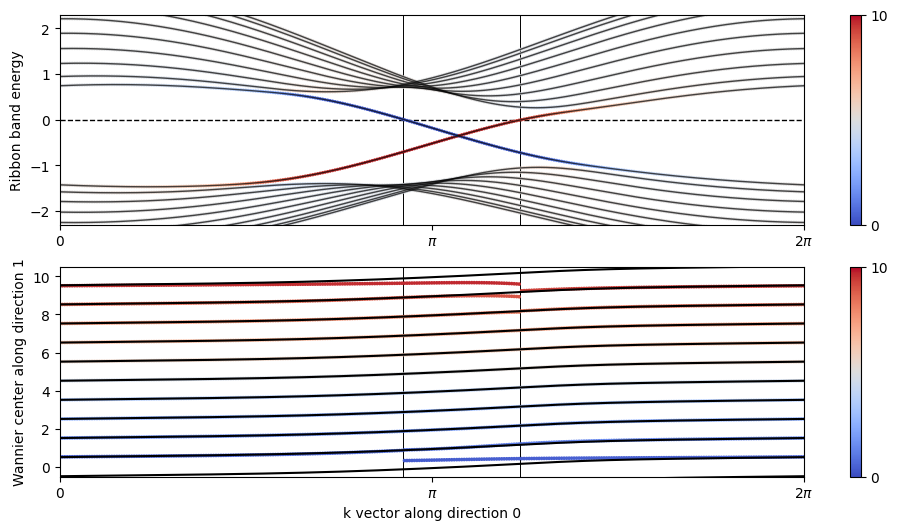

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

# plot bandstructure of the ribbon
ax1.plot(k_dist, rib_eval, c="k", zorder=2, alpha=0.7, lw=1)

# plot band structure with position expec. coloring
for band in range(rib_eval.shape[1]):
    sc = ax1.scatter(
        k_dist, rib_eval[:, band],
        c=pos_exps[:, band], cmap='coolwarm',
        vmin=0, vmax=float(n_layers), s=2, marker="o", zorder=1
    )

# color scale
fig.colorbar(sc, ax=ax1, ticks=[0.0, float(n_layers)])

# plot Fermi energy
ax1.axhline(0.0, c="k", ls="--", lw=1,zorder=-200)

# vertical lines show crossings of surface bands with Fermi energy
for ax in [ax1, ax2]:
    for i in jump_k:
        ax.axvline(
            x=(k_vec[i] + k_vec[i + 1]) / 2.0, linewidth=0.7, color="k", zorder=-150
        )

# tweaks
ax1.set_ylabel("Ribbon band energy")
ax1.set_ylim(-2.3, 2.3)

# plot bulk hybrid Wannier center positions and their periodic images
for j in range(-1, n_layers + 1):
    ax2.plot(k_vec, j + phi_1 / (2 * np.pi), "k-", zorder=2)

# plot finite centers of ribbon along direction 1
for i in range(rib_evec.shape[0]):
    # get occupied states only (those below Fermi level)
    occ_evec = rib_evec[i, rib_eval[i, :] < 0.0]
    # get centers of hybrid wannier functions
    hwfc = ribbon_model.position_hwf(occ_evec, 1)
    # plot centers
    s = ax2.scatter(
        [k_vec[i]] * hwfc.shape[0],
        hwfc,
        c=hwfc,
        s=7,
        marker="o",
        cmap="coolwarm",
        edgecolors="none",
        vmin=0.0,
        vmax=float(n_layers),
        zorder=1,
    )

# color scale
fig.colorbar(s, None, ax2, ticks=[0, float(n_layers)])

# tweaks
ax2.set_xlabel(r"k vector along direction 0")
ax2.set_ylabel(r"Wannier center along direction 1")
ax2.set_ylim(-0.5, n_layers + 0.5)

# label both axes
for ax in [ax1, ax2]:
    ax.set_xlim(k_node[0], k_node[-1])
    ax.set_xticks(k_node)
    ax.set_xticklabels(k_label)